# 4.4.6. Biases of segmentation metrics

Reproducing these results from scratch requires first downloading the MoNuSAC testing data and annotations, and the available teams predictions released by the challenge organizers on the [challenge website](https://monusac-2020.grand-challenge.org/Data/).

In [16]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm
import pickle

In [15]:
from skimage.measure import find_contours

from datasets.monusac import get_all_nuclei, CELL_TYPES, LABELS_COLORS, LABELS_CHANNELS, generate_nary_masks_from_colorcoded
from metrics.segmentation import IoU, DSC, uaIoU, uaDSC, HD, IoU_cm, DSC_cm

In [9]:
# CHANGE TO THE LOCATION OF THE EXTRACTED MoNuSAC data
TESTING_DATA = "e:/data/MoNuSAC/MoNuSAC Testing Data and Annotations/"
TEAMS_DIRECTORY = "e:/data/MoNuSAC/Teams/" # each team's predictions should be in a subdirectory with the name of the team -> "Amirreza Mahbod", "IIAI", "SharifHooshPardaz" and "SJTU_426"

teams = ["Amirreza Mahbod", "IIAI", "SharifHooshPardaz", "SJTU_426"]
teams_dir = {}
for team in teams:
    teams_dir[team] = os.path.join(TEAMS_DIRECTORY, team)

**Loading all nuclei masks & cropped images**

This can be done from scratch with the get_all_nuclei and methods, or by loading the pickel file.

In [ ]:
nuclei = get_all_nuclei(TESTING_DATA)

In [ ]:
# Save to reuse:
with open('./data/monusac_nuclei.pkl', 'wb') as fp:
   pickle.dump(nuclei, fp)

In [6]:
# Load to reuse
with open('./data/monusac_nuclei.pkl', 'rb') as fp:
    nuclei = pickle.load(fp)

**Generating all the teams "n-ary" maps from the color-coded predictions**

In [ ]:
for team_dir in teams_dir.values():
    generate_nary_masks_from_colorcoded(team_dir)

**Effects of position shift example**

Lymphocyte area: 325px


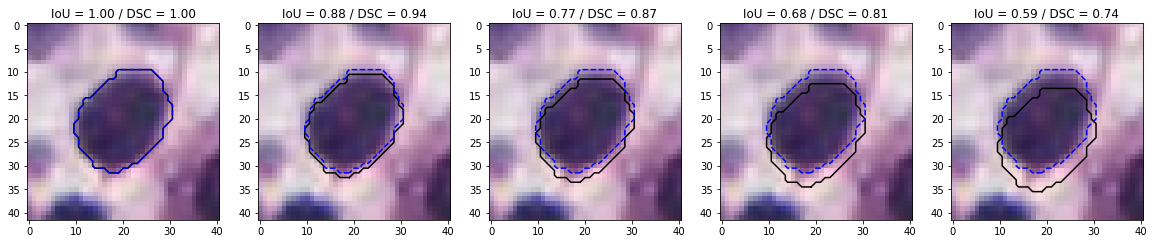

Macrophage area: 10186px


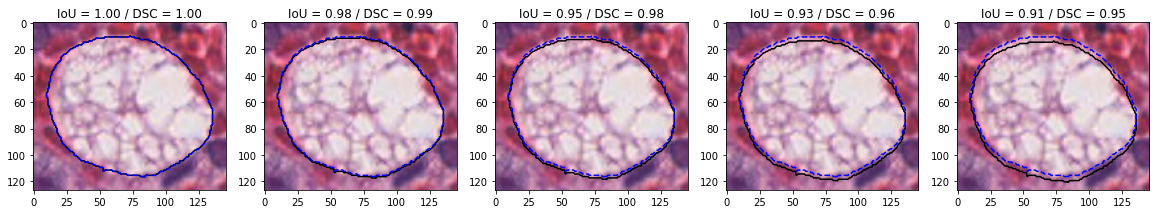

In [3]:
n_shifts = 5
macro = nuclei["Macrophage"][0]
mask_macro = macro.mask
lymph = nuclei["Lymphocyte"][0]
mask_lymph = lymph.mask
print(f"Lymphocyte area: {lymph.mask.sum()}px")

    
plt.figure(figsize=(20,5))
for shift in range(0, n_shifts):
    mask_ref = np.zeros_like(mask_lymph)
    mask_ref[shift:] = mask_lymph[:mask_lymph.shape[0]-shift]
    iou = IoU_cm(mask_lymph > 0, mask_ref > 0, weight_func=None, n=1)
    dsc = DSC_cm(mask_lymph > 0, mask_ref > 0, weight_func=None, n=1)
    contour_gt = find_contours(mask_lymph)[0]
    contour_pred = find_contours(mask_ref)[0]
    plt.subplot(1, n_shifts, shift + 1)
    plt.imshow(lymph.image, interpolation='none')
    plt.plot(contour_pred[:, 1], contour_pred[:, 0], 'k-')
    plt.plot(contour_gt[:, 1], contour_gt[:, 0], 'b--')
    plt.title(f'IoU = {iou:.2f} / DSC = {dsc:.2f}')
plt.show()

print(f"Macrophage area: {macro.mask.sum()}px")

plt.figure(figsize=(20,5))
for shift in range(0, n_shifts):
    mask_ref = np.zeros_like(mask_macro)
    mask_ref[shift:] = mask_macro[:mask_macro.shape[0]-shift]
    iou = IoU_cm(mask_macro > 0, mask_ref > 0, weight_func=None, n=1)
    dsc = DSC_cm(mask_macro > 0, mask_ref > 0, weight_func=None, n=1)
    contour_gt = find_contours(mask_macro)[0]
    contour_pred = find_contours(mask_ref)[0]
    plt.subplot(1, n_shifts, shift + 1)
    plt.imshow(macro.image)
    plt.plot(contour_pred[:, 1], contour_pred[:, 0], 'k-')
    plt.plot(contour_gt[:, 1], contour_gt[:, 0], 'b--')
    plt.title(f'IoU = {iou:.2f} / DSC = {dsc:.2f}')

**Using the uncertainty-aware DSC and IoU**

With $\delta = 1$

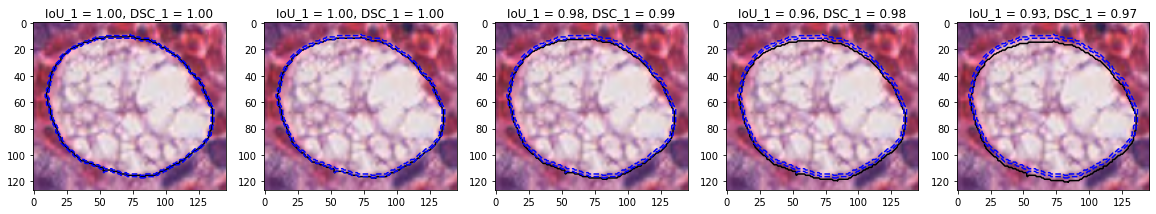

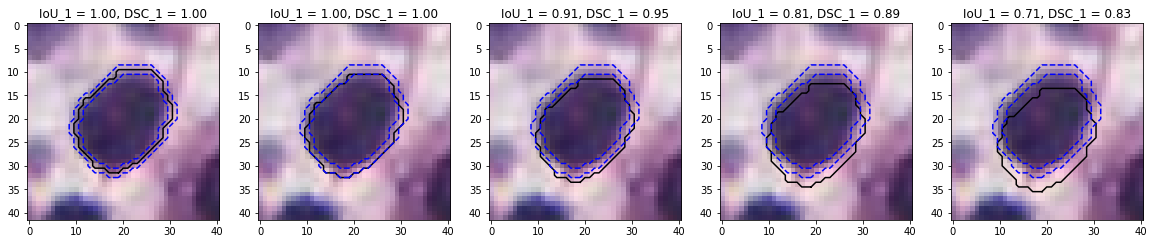

In [18]:
from scipy.ndimage.morphology import distance_transform_edt as edt

n_shifts = 5

plt.figure(figsize=(20,5))
for shift in range(0, n_shifts):
    mask_ref = np.zeros_like(mask_macro)
    mask_ref[shift:] = mask_macro[:mask_macro.shape[0]-shift]
    iou = uaIoU(mask_macro > 0, mask_ref > 0, tau=1)
    dsc = uaDSC(mask_macro > 0, mask_ref > 0, tau=1)
    gt_plus = edt(mask_macro==0) <= 1
    gt_minus = edt(mask_macro) > 1
    contour_gt_plus = find_contours(gt_plus)[0]
    contour_gt_minus = find_contours(gt_minus)[0]
    contour_pred = find_contours(mask_ref)[0]
    plt.subplot(1, n_shifts, shift + 1)
    plt.imshow(macro.image)
    plt.plot(contour_pred[:, 1], contour_pred[:, 0], 'k-')
    plt.plot(contour_gt_plus[:, 1], contour_gt_plus[:, 0], 'b--')
    plt.plot(contour_gt_minus[:, 1], contour_gt_minus[:, 0], 'b--')
    plt.title(f'IoU_1 = {iou:.2f}, DSC_1 = {dsc:.2f}')

plt.figure(figsize=(20,5))
for shift in range(0, n_shifts):
    mask_ref = np.zeros_like(mask_lymph)
    mask_ref[shift:] = mask_lymph[:mask_lymph.shape[0]-shift]
    iou = uaIoU(mask_lymph > 0, mask_ref > 0, tau=1)
    dsc = uaDSC(mask_lymph > 0, mask_ref > 0, tau=1)
    gt_plus = edt(mask_lymph==0) <= 1
    gt_minus = edt(mask_lymph) > 1
    contour_gt_plus = find_contours(gt_plus)[0]
    contour_gt_minus = find_contours(gt_minus)[0]
    contour_gt = find_contours(mask_lymph)[0]
    contour_pred = find_contours(mask_ref)[0]
    plt.subplot(1, n_shifts, shift + 1)
    plt.imshow(lymph.image, interpolation='none')
    plt.plot(contour_pred[:, 1], contour_pred[:, 0], 'k-')
    plt.plot(contour_gt_plus[:, 1], contour_gt_plus[:, 0], 'b--')
    plt.plot(contour_gt_minus[:, 1], contour_gt_minus[:, 0], 'b--')
    plt.title(f'IoU_1 = {iou:.2f}, DSC_1 = {dsc:.2f}')
plt.show()

**Relationship between object area and IoU**

After a single pixel vertical shift:

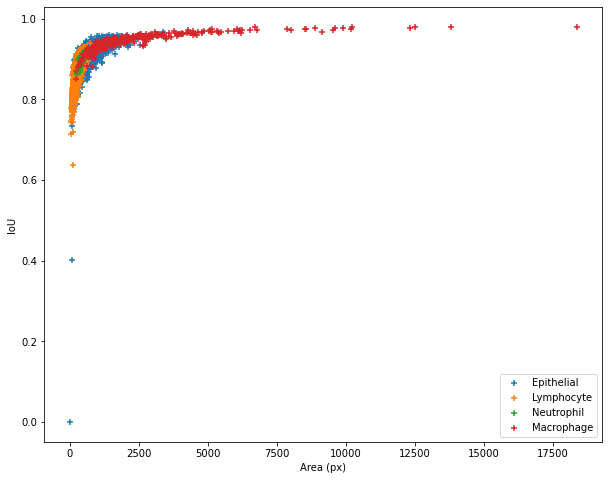

In [4]:
from iou_small_error import plot_class_scatterplots, get_all_IoUs_shift

masks = {}
for cl_type, nuclei_cl in nuclei.items():
    masks[cl_type] = [nucleus.mask for nucleus in nuclei_cl]
    
areas = {}
for cl_type, nuclei_cl in nuclei.items():
    areas[cl_type] = [nucleus.area for nucleus in nuclei_cl]

IoUs_single_px_shift = get_all_IoUs_shift(masks, shift=1)
plot_class_scatterplots(areas, IoUs_single_px_shift, 'Area (px)', 'IoU')

In the results of "Team 1"

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 840.61it/s]


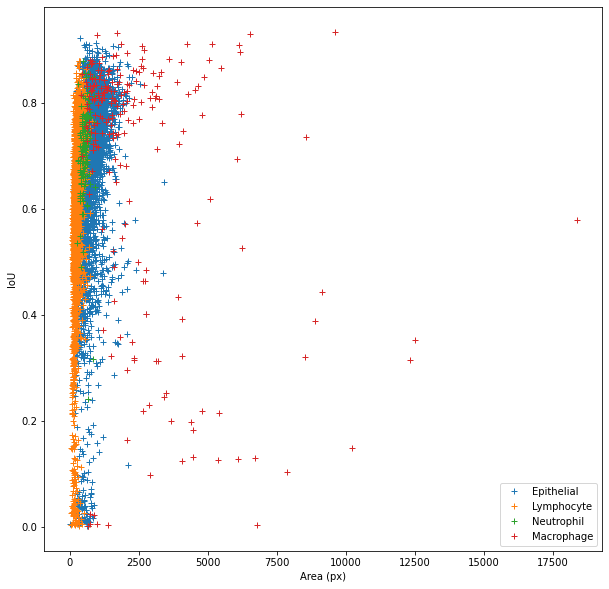

In [14]:
team_dir = teams_dir["Amirreza Mahbod"]
IoUs_vs_areas = {}
for cl in CELL_TYPES:
    IoUs_vs_areas[cl] = []
    current_file = ''
    for nucleus in tqdm(nuclei[cl]):
        image_file = nucleus.image_path.split('/')[-1]
        if image_file != current_file:
            nary_team = np.load(f'{os.path.join(team_dir, image_file)}_nary.npy')
            current_file = image_file
        region = nary_team[nucleus.bbox[0]-10:nucleus.bbox[2]+10, nucleus.bbox[1]-10:nucleus.bbox[3]+10]
        try:
            possible_matches = np.unique(region[nucleus.mask, 0])
        except IndexError:
            continue
        best_match = 0
        best_iou = 0
        for match in possible_matches:
            if match == 0:
                continue
            iou = IoU(nucleus.mask, region[..., 0] == match)
            if iou > best_iou:
                best_iou = iou
                best_match = match
        if best_match > 0:
            IoUs_vs_areas[cl].append([best_iou, nucleus.area])

plt.figure(figsize=(10,10))
for cl in CELL_TYPES:
    iou_area = np.array(IoUs_vs_areas[cl])
    plt.plot(iou_area[:, 1], iou_area[:, 0], '+', label=cl)
plt.xlabel('Area (px)')
plt.ylabel('IoU')
plt.legend(loc=4)
plt.show()

**Examples of teams predictions**

Pixel area: 220


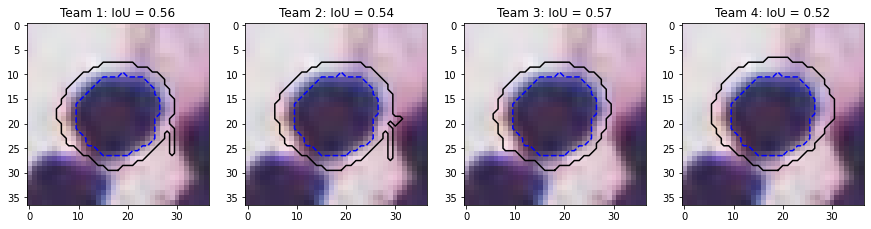

Pixel area: 491


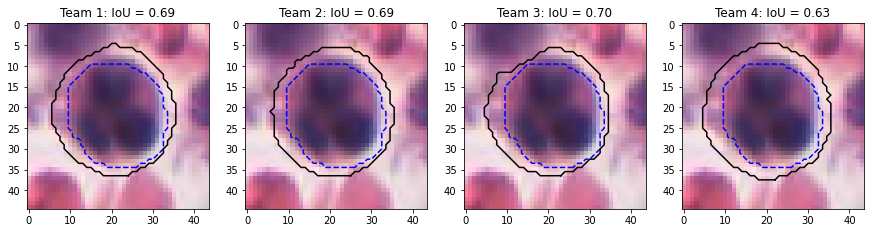

Pixel area: 317


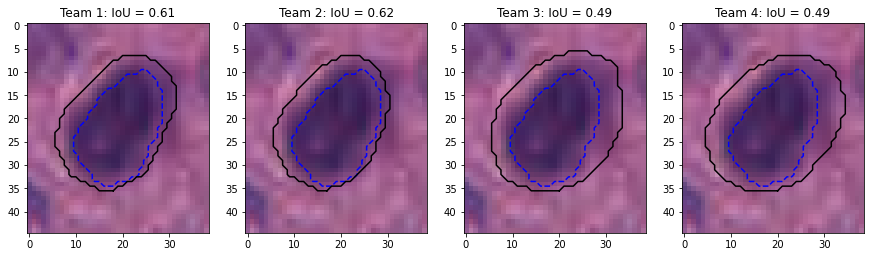

Pixel area: 9608


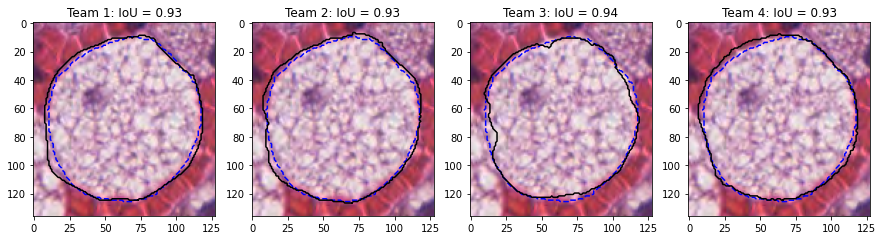

Pixel area: 1876


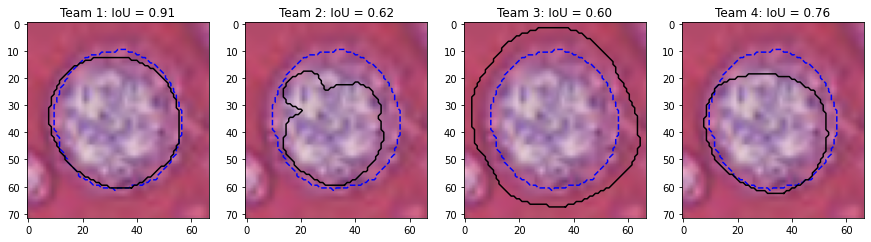

In [19]:
# Checking results for a single nucleus:

nuclei_to_show = [
    nuclei['Lymphocyte'][15], 
    nuclei['Neutrophil'][2], 
    nuclei['Epithelial'][2], 
    nuclei['Macrophage'][3], 
    nuclei['Macrophage'][11]
]

for nucleus in nuclei_to_show:
    image_file = nucleus.image_path.split('/')[-1]
    im = nucleus.image
    print(f"Pixel area: {nucleus.mask.sum()}")

    plt.figure(figsize=(15,5))
    contour_gt = find_contours(nucleus.mask)[0]
    for idt, (team, team_dir) in enumerate(teams_dir.items()):
        plt.subplot(1, len(teams_dir), idt+1)
        nary_team = np.load(f'{os.path.join(team_dir, image_file)}_nary.npy')
        region = nary_team[nucleus.bbox[0]-10:nucleus.bbox[2]+10, nucleus.bbox[1]-10:nucleus.bbox[3]+10]
        possible_matches = np.unique(region[nucleus.mask, 0])
        best_match = 0
        best_iou = 0
        plt.imshow(im)
        plt.plot(contour_gt[:, 1], contour_gt[:, 0], 'b--')

        for match in possible_matches:
            if match == 0:
                continue
            iou = IoU(nucleus.mask, region[..., 0] == match)
            if iou > best_iou:
                best_iou = iou
                best_match = match
        if best_match > 0:
            contour_pred = find_contours(region[..., 0] == best_match)[0]
            plt.plot(contour_pred[:, 1], contour_pred[:, 0], 'k-')
            plt.title(f'Team {idt+1}: IoU = {best_iou:.2f}')
            #plt.title(f'Team {idt+1}: HD = {HD(nucleus.mask, region[..., 0] == best_match):.2f}')
        else:
            plt.title('No match')
    plt.show()

**Distribution of the IoU per class for Team 1**

Using the simple IoU definition, and the uncertainty-aware IoU with $\delta = 2$.

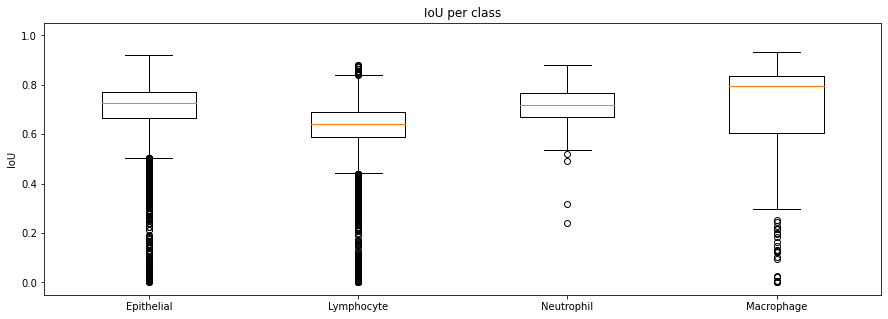

In [20]:
plt.figure(figsize=(15,5))
ious_cl = [np.array(iou_area)[:, 0] for cl, iou_area in IoUs_vs_areas.items()]
plt.boxplot(ious_cl)
plt.xticks(range(1, 5), CELL_TYPES)
plt.ylabel('IoU')
plt.ylim([-0.05, 1.05])
plt.title('IoU per class')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [00:00<00:00, 479.09it/s]


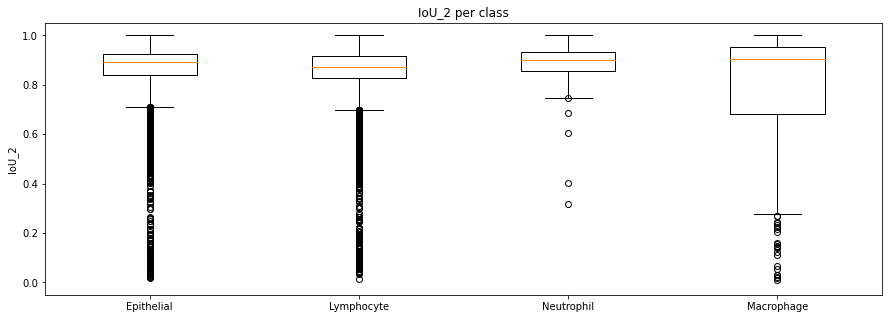

In [21]:
team_dir = teams_dir["Amirreza Mahbod"]
uaIoUs_vs_areas = {}
for cl in CELL_TYPES:
    uaIoUs_vs_areas[cl] = []
    current_file = ''
    for nucleus in tqdm(nuclei[cl]):
        image_file = nucleus.image_path.split('/')[-1]
        if image_file != current_file:
            nary_team = np.load(f'{os.path.join(team_dir, image_file)}_nary.npy')
            current_file = image_file
        region = nary_team[nucleus.bbox[0]-10:nucleus.bbox[2]+10, nucleus.bbox[1]-10:nucleus.bbox[3]+10]
        try:
            possible_matches = np.unique(region[nucleus.mask, 0])
        except IndexError:
            continue
        best_match = 0
        best_iou = 0
        for match in possible_matches:
            if match == 0:
                continue
            iou = uaIoU(nucleus.mask, region[..., 0] == match, tau=2)
            if iou > best_iou:
                best_iou = iou
                best_match = match
        if best_match > 0:
            uaIoUs_vs_areas[cl].append([best_iou, nucleus.area])

plt.figure(figsize=(15,5))
ious_cl = [np.array(iou_area)[:, 0] for cl, iou_area in uaIoUs_vs_areas.items()]
plt.boxplot(ious_cl)
plt.xticks(range(1, 5), CELL_TYPES)
plt.ylabel('IoU_2')
plt.ylim([-0.05, 1.05])
plt.title('IoU_2 per class')
plt.show()

**Effects of over- and under- estimation of the object sizes**

In [22]:
def result_added_pixel(true_area, n):
    TP = true_area
    FP = n
    FN = 0
    return TP/(TP+FP+FN), 2*TP/(2*TP+FP+FN) # IoU, DSC

def result_removed_pixel(true_area, n):
    TP = true_area-n
    FP = 0
    FN = n
    return TP/(TP+FP+FN), 2*TP/(2*TP+FP+FN) # IoU, DSC

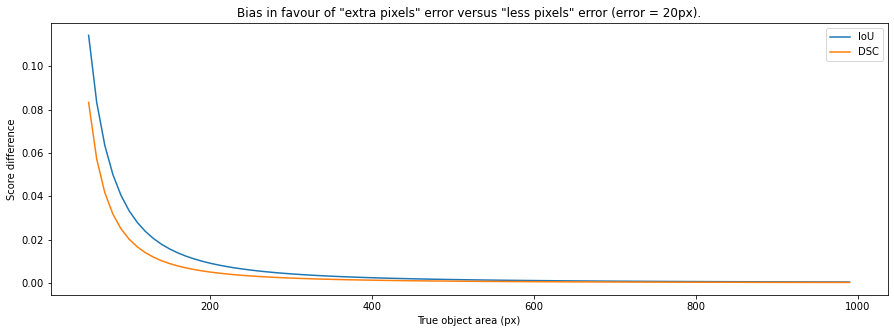

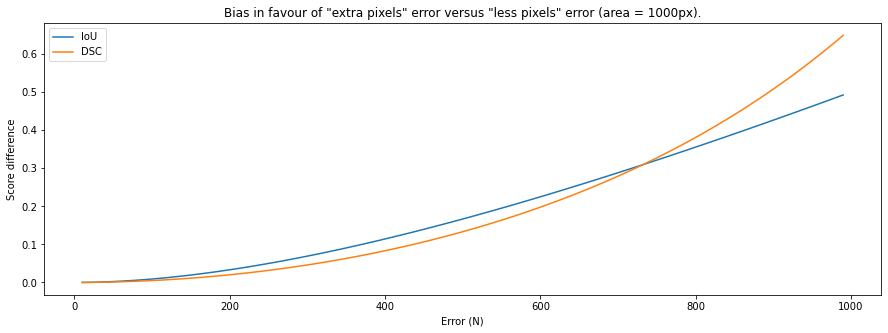

In [23]:
areas = np.arange(50, 1000, 10)
results_added = np.zeros((len(areas),2))
results_removed = np.zeros((len(areas),2))

for i,area in enumerate(areas):
    results_added[i] = result_added_pixel(area, 20)
    results_removed[i] = result_removed_pixel(area, 20)
    
plt.figure(figsize=(15,5))
plt.plot(areas, results_added[:,0]-results_removed[:,0], label='IoU')
plt.plot(areas, results_added[:,1]-results_removed[:,1], label='DSC')
plt.title('Bias in favour of "extra pixels" error versus "less pixels" error (error = 20px).')
plt.legend()
plt.xlabel('True object area (px)')
plt.ylabel('Score difference')
plt.show()

errors = np.arange(10, 1000, 10)
results_added = np.zeros((len(errors),2))
results_removed = np.zeros((len(errors),2))

for i,err in enumerate(errors):
    results_added[i] = result_added_pixel(1000, err)
    results_removed[i] = result_removed_pixel(1000, err)

plt.figure(figsize=(15,5))
plt.plot(errors, results_added[:,0]-results_removed[:,0], label='IoU')
plt.plot(errors, results_added[:,1]-results_removed[:,1], label='DSC')
plt.title('Bias in favour of "extra pixels" error versus "less pixels" error (area = 1000px).')
plt.legend(loc=0)
plt.xlabel('Error (N)')
plt.ylabel('Score difference')
plt.show()